# Observations regarding epsilon, the initial value of z and the ground state
The role of this notebook is to document some changes that I made to the code. The changes are the following:

* Exposed the role of epsilon in connection formation. It appears to me desirable to eliminate the creation of connections to the units that do not participate in any pattern (the ones responsible for the ground state). Epislon can modulate whether this units are created or not. I illustrate this effect. 
* If the traces do not start in 0 and the simulations are not run for long enough then connnections will be create between the free units (the resposible for the ground state) and the first patterns that are activated. This lead me to initialize the values of the traces to 0 instead of 1 / minicolumns as it was before.
* I studied the role of noise in connectivity formation. If we allow the probability traces to keep evolving during the ground state then you end up learning connections that appear due to the noise in the ground state. So far I think that this is undesirable so I took it out.

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib
import seaborn as sns

from network import BCPNNFast, NetworkManager
from data_transformer import build_ortogonal_patterns
from plotting_functions import plot_state_variables_vs_time, plot_network_activity, plot_network_activity_angle
from plotting_functions import  plot_adaptation_dynamics, plot_weight_matrix, plot_winning_pattern

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = 'bf2d407681a44bacb60f3c092f1c38b3648d546d'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

## Role of Epsilon
First we declare all the parameters

In [3]:
# Patterns parameters
hypercolumns = 4
minicolumns = 15
n_patterns = 10  # Number of patterns

# Network parameters
tau_z_pre = 1.000
tau_z_post = 0.125
tau_z_pre_ampa = 0.005
tau_z_post_ampa = 0.005
tau_a = 2.7

# Manager properties
dt = 0.001
T_training = 1.0
T_ground = 3.0
T_recalling = 10.0
values_to_save = ['o', 'a', 'z_pre', 'z_post', 'p_pre', 'p_post', 'p_co', 'z_co', 'w',
                  'z_pre_ampa', 'z_post_ampa', 'p_pre_ampa', 'p_post_ampa', 'p_co_ampa', 'z_co_ampa', 'w_ampa']

We build the patterns to save and build the network and manager

In [4]:
# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
sequence1 = patterns[:5]
sequence2 = patterns[5:10]


# Build the network
nn = BCPNNFast(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre,
               tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, T_training=T_training, T_ground=T_ground, T_recalling=T_recalling,
                         values_to_save=values_to_save)
pprint.pprint(nn.get_parameters())

{'g_I': 10.0,
 'g_a': 97.0,
 'g_beta': 1,
 'g_w': 1,
 'g_w_ampa': 1.0,
 'k': 0.0,
 'sigma': 1.0,
 'tau_a': 2.7,
 'tau_m': 0.05,
 'tau_p': 10.0,
 'tau_z_post': 0.125,
 'tau_z_post_ampa': 0.005,
 'tau_z_pre': 1.0,
 'tau_z_pre_ampa': 0.005}


We do the training with the default epsilon (1e-10)

In [5]:
# Training
repetitions = 2

for i in range(repetitions):
    print('repetitions', i)

    # First sequence
    for pattern in sequence1:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Space between the sequences
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)

    # Second sequence
    for pattern in sequence2:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Second pause
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)


# manager.n_patterns = n_patterns
manager.T_total = (len(sequence1) * (T_training) + len(sequence2) * (T_training) + 2 * T_ground) * repetitions
manager.n_patterns = n_patterns
manager.patterns = patterns

repetitions 0
repetitions 1


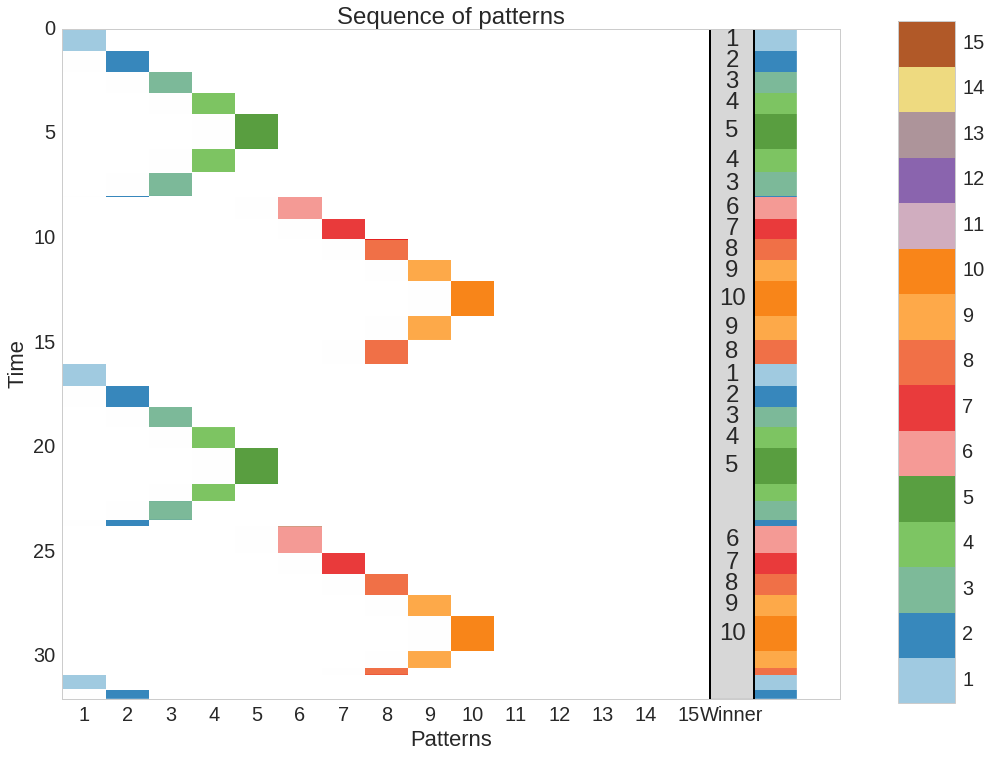

In [6]:
plot_winning_pattern(manager, separators=False, remove=T_training - 0.1)

What we are training here is two sequences of fives two times.

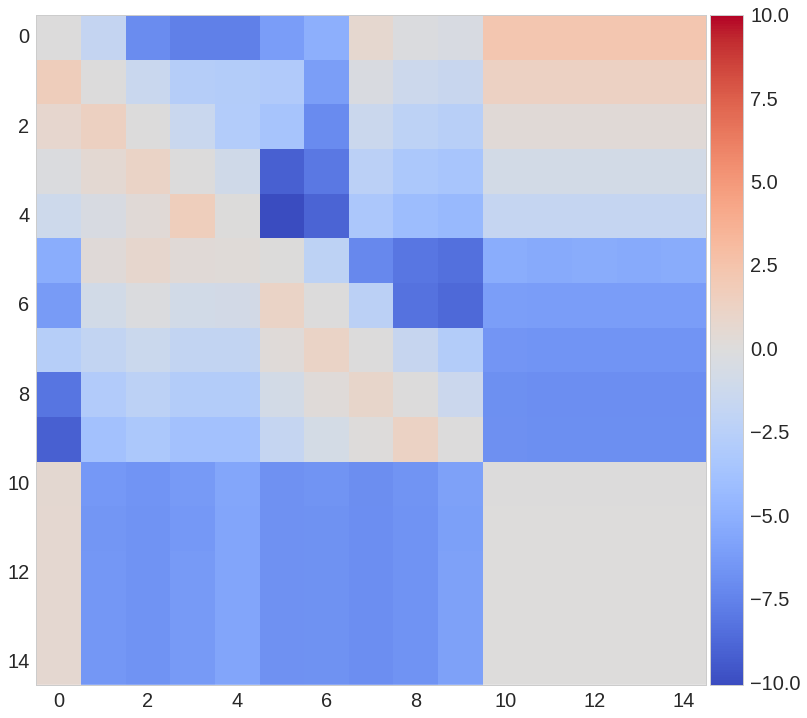

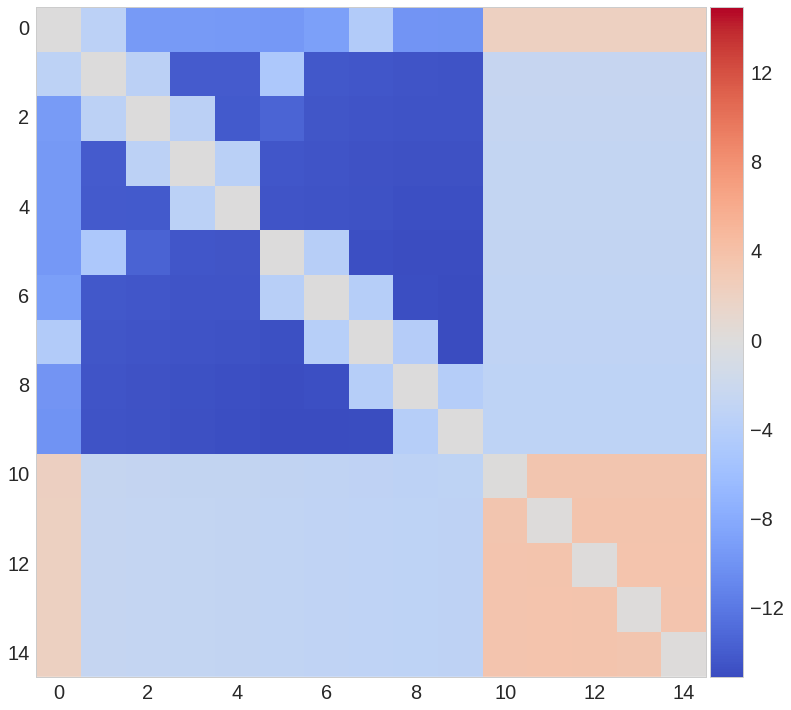

In [7]:
plot_weight_matrix(nn, ampa=False, one_hypercolum=True)
plot_weight_matrix(nn, ampa=True, one_hypercolum=True)

We see that athere are connections between the units that are not used and the ones that are.

Now we reset the network and run the network with a epislon that discriminates more

In [8]:
nn.reset_values()
manager.empty_history()
nn.epsilon = 5e-3

# Training
repetitions = 2

for i in range(repetitions):
    print('repetitions', i)

    # First sequence
    for pattern in sequence1:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Space between the sequences
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)

    # Second sequence
    for pattern in sequence2:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Second pause
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)


# manager.n_patterns = n_patterns
manager.T_total = (len(sequence1) * (T_training) + len(sequence2) * (T_training) + 2 * T_ground) * repetitions
manager.n_patterns = n_patterns
manager.patterns = patterns

repetitions 0
repetitions 1


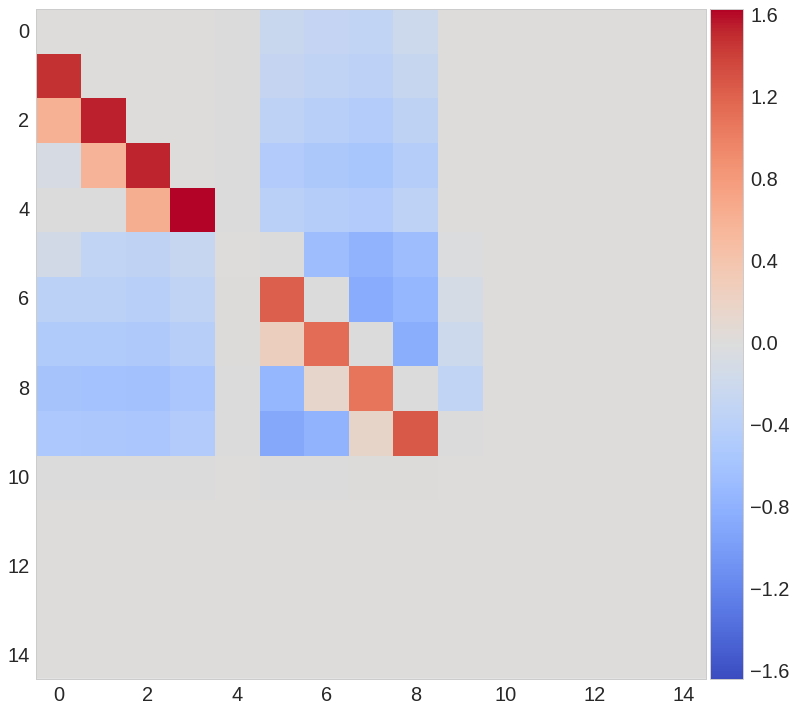

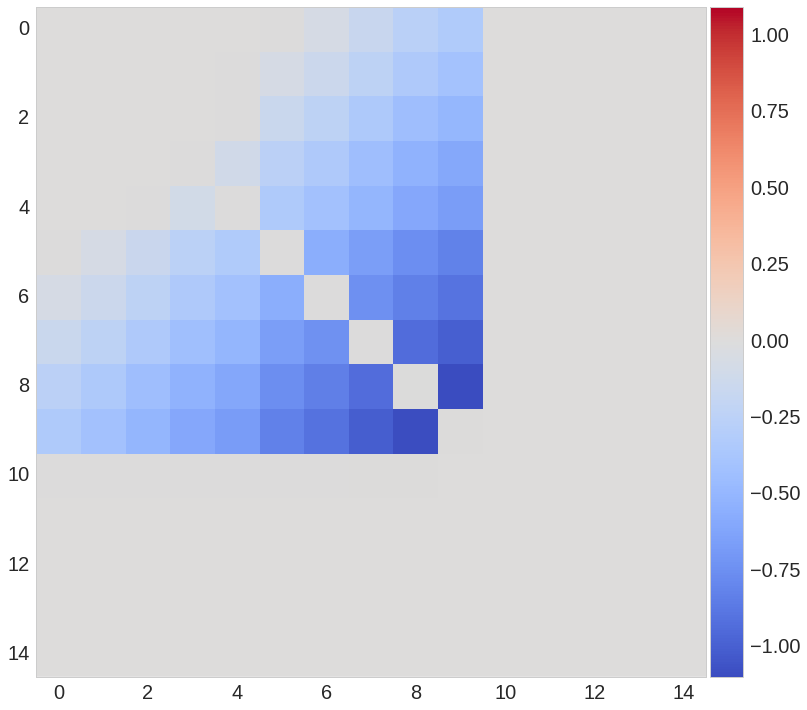

In [9]:
plot_weight_matrix(nn, ampa=False, one_hypercolum=True)
plot_weight_matrix(nn, ampa=True, one_hypercolum=True)

We can observe that we have eliminated the connections between the units that are not used for storing patterns and the ones that are used. This is because **the weak probability traces that are smaller than epsilon are not counted for synapse formation**

## Role of traces

We build the network again but we will initialize the z-traces to values 0 first (the default) and then to 1 / minicolumns to compare the connections that were created by this two different processes

In [10]:
# Build the network
nn = BCPNNFast(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre,
               tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, T_training=T_training, T_ground=T_ground, T_recalling=T_recalling,
                         values_to_save=values_to_save)
pprint.pprint(nn.get_parameters())

{'g_I': 10.0,
 'g_a': 97.0,
 'g_beta': 1,
 'g_w': 1,
 'g_w_ampa': 1.0,
 'k': 0.0,
 'sigma': 1.0,
 'tau_a': 2.7,
 'tau_m': 0.05,
 'tau_p': 10.0,
 'tau_z_post': 0.125,
 'tau_z_post_ampa': 0.005,
 'tau_z_pre': 1.0,
 'tau_z_pre_ampa': 0.005}


We do the training

In [11]:
# Training
repetitions = 2

for i in range(repetitions):
    print('repetitions', i)

    # First sequence
    for pattern in sequence1:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Space between the sequences
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)

    # Second sequence
    for pattern in sequence2:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Second pause
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)


# manager.n_patterns = n_patterns
manager.T_total = (len(sequence1) * (T_training) + len(sequence2) * (T_training) + 2 * T_ground) * repetitions
manager.n_patterns = n_patterns
manager.patterns = patterns

repetitions 0
repetitions 1


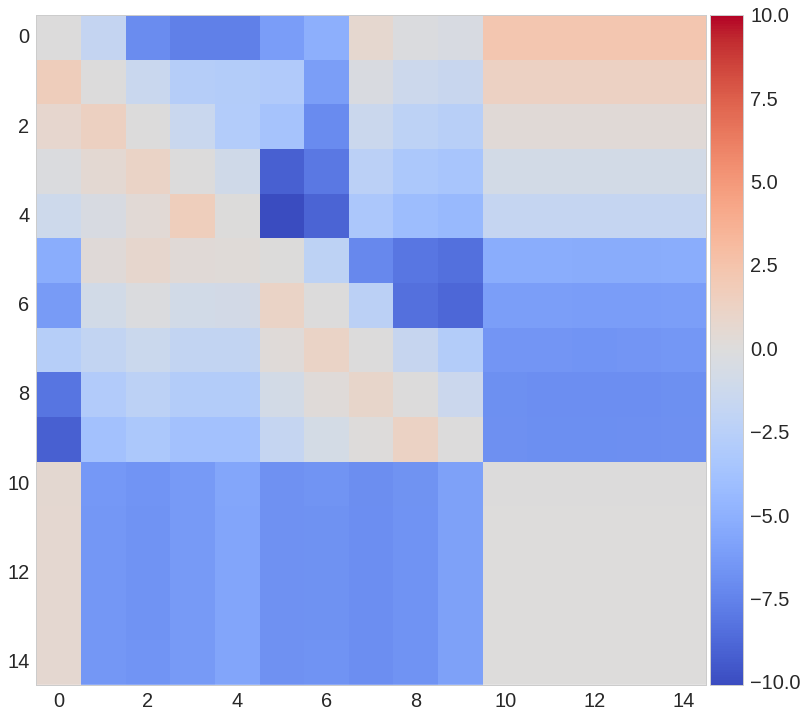

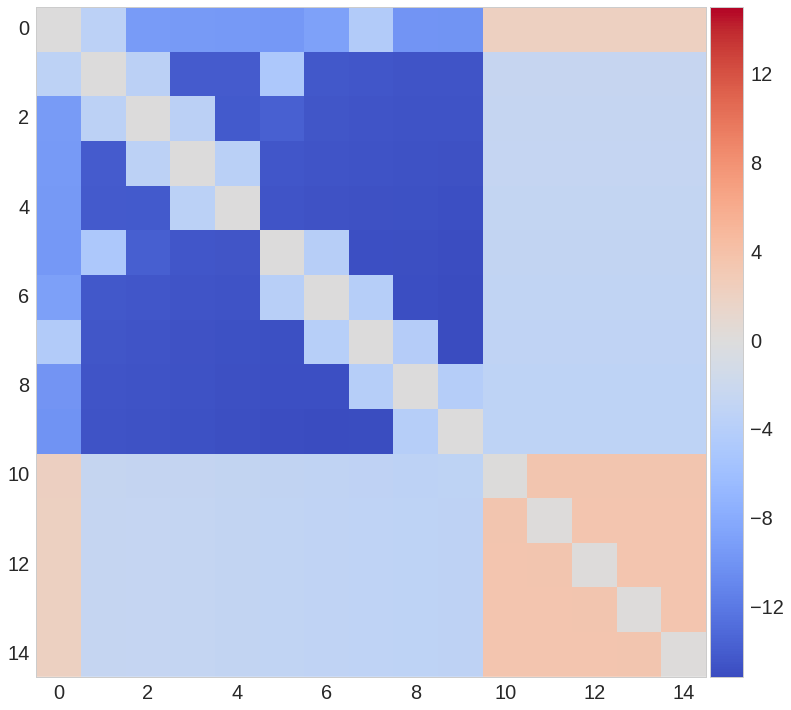

In [12]:
plot_weight_matrix(nn, ampa=False, one_hypercolum=True)
plot_weight_matrix(nn, ampa=True, one_hypercolum=True)

In [13]:
nn.reset_values()
manager.empty_history()

nn.z_pre_ampa = np.ones(nn.n_units) * 1.0/ nn.minicolumns
nn.z_post_ampa = np.ones(nn.n_units) * 1.0/ nn.minicolumns
nn.z_pre = np.ones(nn.n_units) * 1.0/ nn.minicolumns
nn.z_post = np.ones(nn.n_units) * 1.0/ nn.minicolumns

We do the training again

In [14]:
# Training
repetitions = 2

for i in range(repetitions):
    print('repetitions', i)

    # First sequence
    for pattern in sequence1:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Space between the sequences
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)

    # Second sequence
    for pattern in sequence2:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Second pause
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)


# manager.n_patterns = n_patterns
manager.T_total = (len(sequence1) * (T_training) + len(sequence2) * (T_training) + 2 * T_ground) * repetitions
manager.n_patterns = n_patterns
manager.patterns = patterns

repetitions 0
repetitions 1


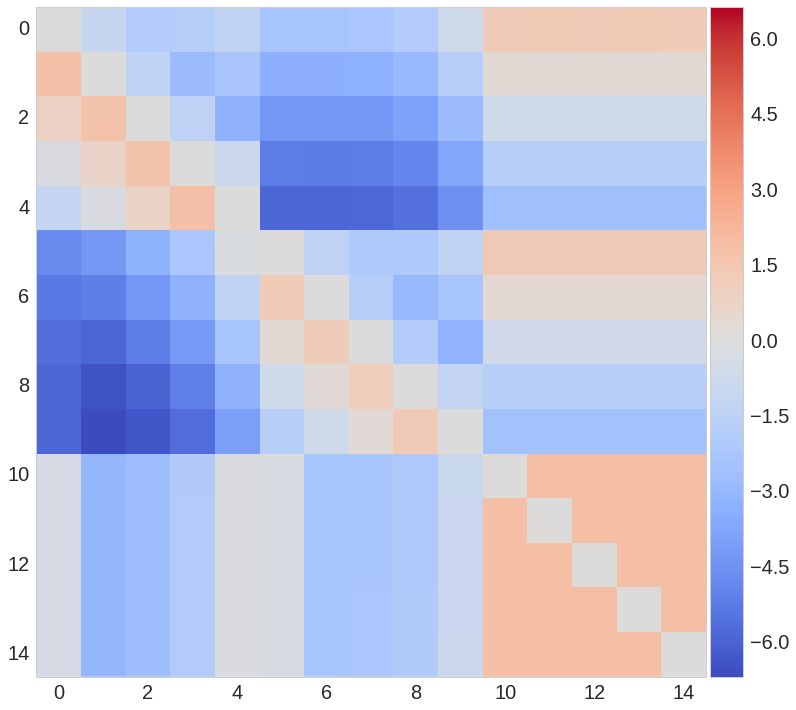

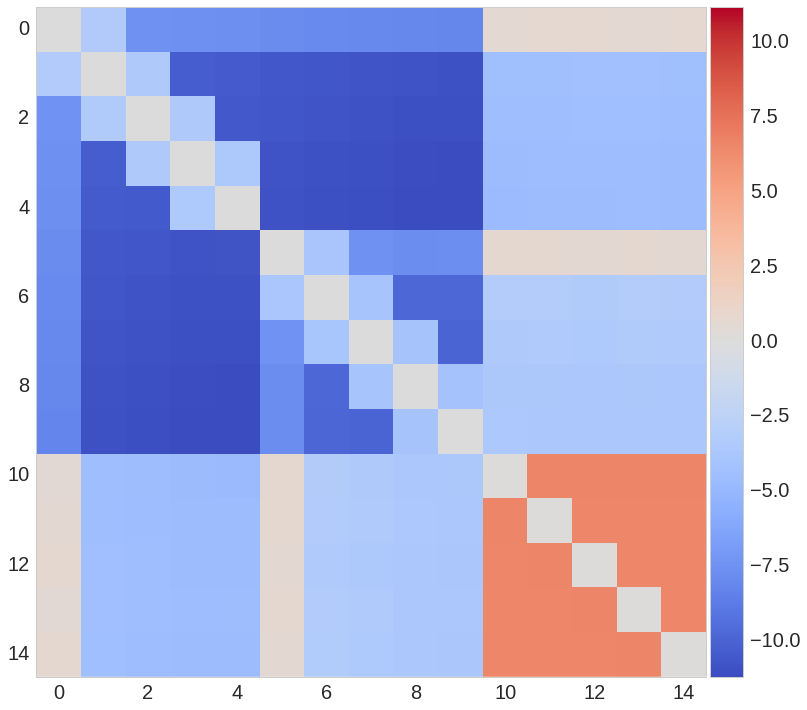

In [15]:
plot_weight_matrix(nn, ampa=False, one_hypercolum=True)
plot_weight_matrix(nn, ampa=True, one_hypercolum=True)

We can appreciate that the the connection among the units that do not participate in the pattern (low-right corner) become stronger among themselves. 

## Ground state
Allowing the values to evolve during the ground state. First we run the network were we do not allow this to happen 

In [16]:
# Build the network
nn = BCPNNFast(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre,
               tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, T_training=T_training, T_ground=T_ground, T_recalling=T_recalling,
                         values_to_save=values_to_save)
pprint.pprint(nn.get_parameters())

{'g_I': 10.0,
 'g_a': 97.0,
 'g_beta': 1,
 'g_w': 1,
 'g_w_ampa': 1.0,
 'k': 0.0,
 'sigma': 1.0,
 'tau_a': 2.7,
 'tau_m': 0.05,
 'tau_p': 10.0,
 'tau_z_post': 0.125,
 'tau_z_post_ampa': 0.005,
 'tau_z_pre': 1.0,
 'tau_z_pre_ampa': 0.005}


We do the training

In [17]:
# Training
repetitions = 2

for i in range(repetitions):
    print('repetitions', i)

    # First sequence
    for pattern in sequence1:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Space between the sequences
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)

    # Second sequence
    for pattern in sequence2:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Second pause
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)


# manager.n_patterns = n_patterns
manager.T_total = (len(sequence1) * (T_training) + len(sequence2) * (T_training) + 2 * T_ground) * repetitions
manager.n_patterns = n_patterns
manager.patterns = patterns

repetitions 0
repetitions 1


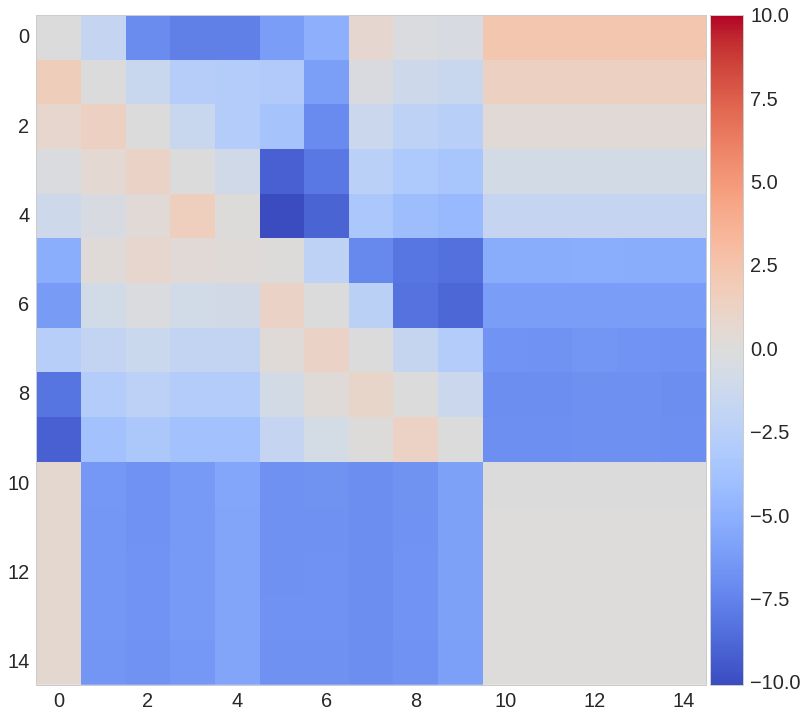

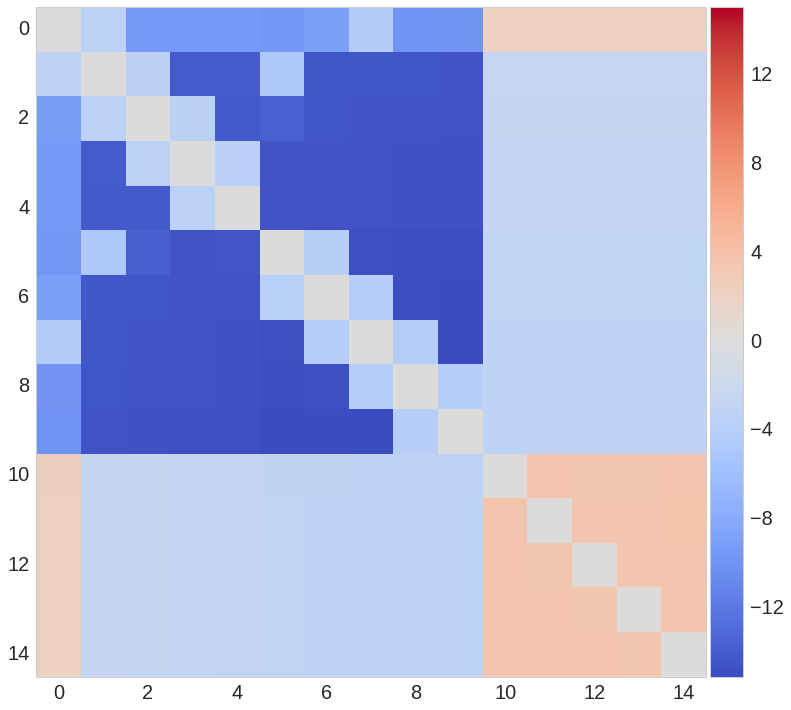

In [18]:
plot_weight_matrix(nn, ampa=False, one_hypercolum=True)
plot_weight_matrix(nn, ampa=True, one_hypercolum=True)

We now defined a modified class for BCPNN with the movement of the probabilities in the ground state

In [22]:
from connectivity_functions import softmax, get_w_pre_post, get_beta, epsilon, log_epsilon

class BCPNNFast:
    def __init__(self, hypercolumns, minicolumns, beta=None, w=None, G=1.0, tau_m=0.050, g_w=1, g_w_ampa=1.0, g_beta=1,
                 tau_z_pre=0.240, tau_z_post=0.240, tau_z_pre_ampa=0.005, tau_z_post_ampa=0.005, tau_p=10.0,
                 tau_a=2.70, g_a=97.0, g_I=10.0, k=0.0, sigma=1.0, epsilon=1e-10, prng=np.random):
        # Initial values are taken from the paper on memory by Marklund and Lansner.

        # Random number generator
        self.prng = prng
        self.sigma = sigma
        self.epsilon = epsilon

        # Network parameters
        self.hypercolumns = hypercolumns
        self.minicolumns = minicolumns

        self.n_units = self.hypercolumns * self.minicolumns

        # Connectivity
        self.beta = beta
        self.w = w

        #  Dynamic Parameters
        self.G = G
        self.tau_m = tau_m
        self.tau_z_pre = tau_z_pre
        self.tau_z_post = tau_z_post
        self.tau_z_pre_ampa = tau_z_pre_ampa
        self.tau_z_post_ampa = tau_z_post_ampa
        self.tau_p = tau_p
        self.tau_a = tau_a
        self.k = k
        self.g_a = g_a
        self.g_w = g_w
        self.g_w_ampa = g_w_ampa
        self.g_beta = g_beta
        self.g_I = g_I

        # If state variables and parameters are not initialized

        self.o = np.ones(self.hypercolumns * self.minicolumns) * (1.0 / self.minicolumns)
        self.s = np.log(np.ones(self.hypercolumns * self.minicolumns) * (1.0 / self.minicolumns))
        self.beta = np.log(np.ones_like(self.o) * (1.0 / self.minicolumns))

        # NMDA values
        self.z_pre = np.zeros_like(self.o)
        self.z_post = np.zeros_like(self.o)
        self.p_pre = np.zeros_like(self.o)
        self.p_post = np.zeros_like(self.o)
        self.p_co = np.zeros((self.o.size, self.o.size))
        self.w = np.zeros((self.n_units, self.n_units))

        # Ampa values
        self.z_pre_ampa = np.zeros_like(self.o)
        self.z_post_ampa = np.zeros_like(self.o)
        self.p_pre_ampa = np.zeros_like(self.o)
        self.p_post_ampa = np.zeros_like(self.o)
        self.p_co_ampa = np.zeros((self.o.size, self.o.size))
        self.w_ampa = np.zeros((self.n_units, self.n_units))

        # Set the coactivations to a default
        self.z_co = np.zeros((self.n_units, self.n_units))
        self.z_co_ampa = np.zeros((self.n_units, self.n_units))

        # Set the adaptation to zeros by default
        self.a = np.zeros_like(self.o)
        # Set the clamping to zero by defalut
        self.I = np.zeros_like(self.o)

    def get_parameters(self):
        """
        Get the parameters of the model

        :return: a dictionary with the parameters
        """
        parameters = {'tau_m': self.tau_m, 'tau_z_post': self.tau_z_post, 'tau_z_pre': self.tau_z_pre,
                      'tau_p': self.tau_p, 'tau_a': self.tau_a, 'g_a': self.g_a, 'g_w': self.g_w,
                      'g_beta': self.g_beta, 'g_I':self.g_I, 'sigma':self.sigma, 'k': self.k, 'g_w_ampa': self.g_w_ampa,
                      'tau_z_post_ampa': self.tau_z_post_ampa, 'tau_z_pre_ampa': self.tau_z_pre_ampa}

        return parameters

    def reset_values(self, keep_connectivity=True):
        self.o = np.ones(self.n_units) * (1.0 / self.minicolumns)
        self.s = np.log(np.ones(self.n_units) * (1.0 / self.minicolumns))

        # NMDA values
        self.z_pre = np.zeros_like(self.o)
        self.z_post = np.zeros_like(self.o)
        self.p_pre = np.zeros_like(self.o)
        self.p_post = np.zeros_like(self.o)
        self.p_co = np.zeros((self.o.size, self.o.size))

        # Ampa values
        self.z_pre_ampa = np.zeros_like(self.o)
        self.z_post_ampa = np.zeros_like(self.o)
        self.p_pre_ampa = np.zeros_like(self.o)
        self.p_post_ampa = np.zeros_like(self.o)
        self.p_co_ampa = np.zeros((self.o.size, self.o.size))

        # Set the coactivations to a default
        self.z_co = np.zeros((self.n_units, self.n_units))
        self.z_co_ampa = np.zeros((self.n_units, self.n_units))

        self.a = np.zeros_like(self.o)

        if not keep_connectivity:
            self.beta = np.log(np.ones_like(self.o) * (1.0 / self.minicolumns))
            self.w = np.zeros((self.n_units, self.n_units))
            self.w_ampa = np.zeros((self.n_units, self.n_units))

    def randomize_pattern(self):
        self.o = self.prng.rand(self.n_units)
        self.s = np.log(self.prng.rand(self.n_units))

        self.z_pre = self.prng.rand(self.n_units)
        self.z_pre_ampa = self.prng.rand(self.n_units)

        # A follows, if o is randomized sent a to zero.
        self.a = np.zeros_like(self.o)

    def update_continuous(self, dt=1.0, sigma=None):

        if sigma is None:
            sigma = self.prng.normal(0, self.sigma, self.n_units)

        # Updated the probability and the support
        self.s += (dt / self.tau_m) * (self.g_w * np.dot(self.w, self.z_pre)  # NMDA effects
                                       + self.g_w_ampa * np.dot(self.w_ampa, self.z_pre_ampa)  # Ampa effects
                                       + self.g_beta * self.beta  # Bias
                                       + self.g_I * log_epsilon(self.I)  # Input current
                                       - self.s  # s follow all of hte above
                                       - self.g_a * self.a  # Adaptation
                                       + sigma) # This last term is the noise


        # Softmax
        self.o = softmax(self.s, t=(1/self.G), minicolumns=self.minicolumns)

        # Update the adaptation
        self.a += (dt / self.tau_a) * (self.o - self.a)

        # Updated the z-traces
        self.z_pre += (dt / self.tau_z_pre) * (self.o - self.z_pre)
        self.z_post += (dt / self.tau_z_post) * (self.o - self.z_post)
        self.z_co = np.outer(self.z_post, self.z_pre)

        # Updated the z-traces AMPA
        self.z_pre_ampa += (dt / self.tau_z_pre_ampa) * (self.o - self.z_pre_ampa)
        self.z_post_ampa += (dt / self.tau_z_post_ampa) * (self.o - self.z_post_ampa)
        self.z_co_ampa = np.outer(self.z_post_ampa, self.z_pre_ampa)
        
        # Updated the probability of the NMDA connection
        self.p_pre += (dt / self.tau_p) * (self.z_pre - self.p_pre)
        self.p_post += (dt / self.tau_p) * (self.z_post - self.p_post)
        self.p_co += (dt / self.tau_p) * (self.z_co - self.p_co)

        # Updated the probability of AMPA connection
        self.p_pre_ampa += (dt / self.tau_p) * (self.z_pre_ampa - self.p_pre_ampa)
        self.p_post_ampa += (dt / self.tau_p) * (self.z_post_ampa - self.p_post_ampa)
        self.p_co_ampa += (dt / self.tau_p) * (self.z_co_ampa - self.p_co_ampa)

        if self.k > epsilon:
            self.beta = get_beta(self.p_post)
            self.w_ampa = get_w_pre_post(self.p_co_ampa, self.p_pre_ampa, self.p_post_ampa, self.epsilon)
            self.w = get_w_pre_post(self.p_co, self.p_pre, self.p_post, self.epsilon)


We build the network again and train

In [23]:
# Build the network
nn = BCPNNFast(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre,
               tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, T_training=T_training, T_ground=T_ground, T_recalling=T_recalling,
                         values_to_save=values_to_save)
pprint.pprint(nn.get_parameters())

{'g_I': 10.0,
 'g_a': 97.0,
 'g_beta': 1,
 'g_w': 1,
 'g_w_ampa': 1.0,
 'k': 0.0,
 'sigma': 1.0,
 'tau_a': 2.7,
 'tau_m': 0.05,
 'tau_p': 10.0,
 'tau_z_post': 0.125,
 'tau_z_post_ampa': 0.005,
 'tau_z_pre': 1.0,
 'tau_z_pre_ampa': 0.005}


In [24]:
# Training
repetitions = 2

for i in range(repetitions):
    print('repetitions', i)

    # First sequence
    for pattern in sequence1:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Space between the sequences
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)

    # Second sequence
    for pattern in sequence2:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Second pause
    nn.k = 0.0
    manager.run_network(time=manager.time_ground)


# manager.n_patterns = n_patterns
manager.T_total = (len(sequence1) * (T_training) + len(sequence2) * (T_training) + 2 * T_ground) * repetitions
manager.n_patterns = n_patterns
manager.patterns = patterns

repetitions 0
repetitions 1


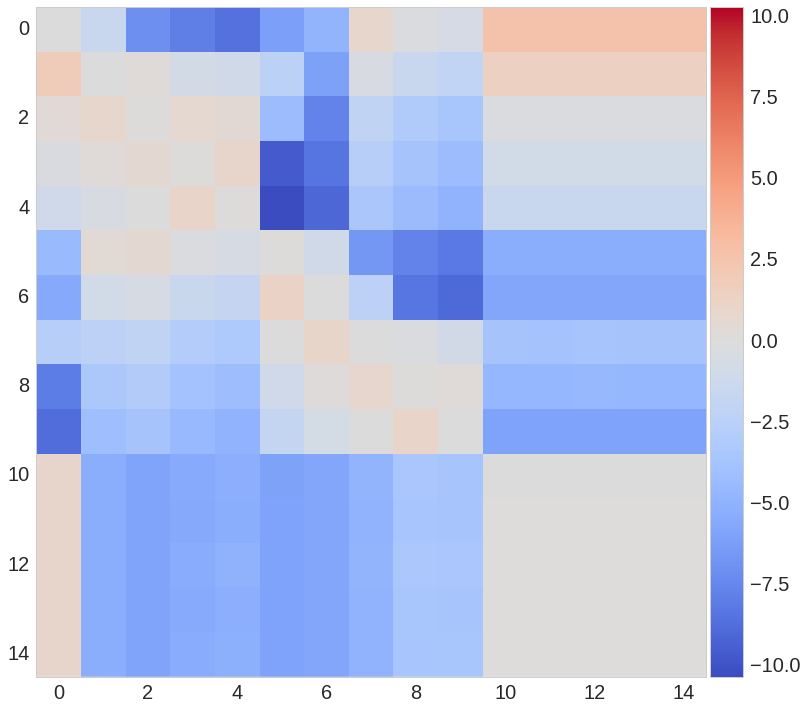

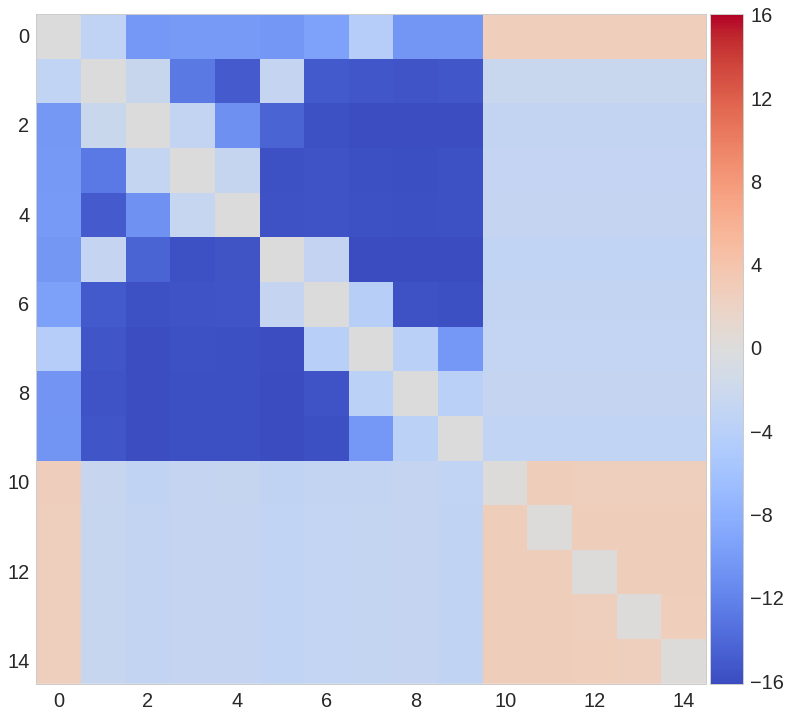

In [25]:
plot_weight_matrix(nn, ampa=False, one_hypercolum=True)
plot_weight_matrix(nn, ampa=True, one_hypercolum=True)